## Explore Programs Offered

Notice that of the institutions with data, a large proportion offer only a few programs. Upon close inspection, these appear to be highly specialized trade schools

In [28]:
data.PRGMOFR.value_counts()[:10]

1.0     379
2.0     352
3.0     342
4.0     309
5.0     214
6.0     156
7.0     105
9.0      72
8.0      60
10.0     43
Name: PRGMOFR, dtype: int64

In [29]:
data[data.PRGMOFR<=10].INSTNM

17         New Beginning College of Cosmetology
60           Alaska Vocational Technical Center
62                        Alaska Career College
63                  Empire Beauty School-Tucson
64             Carrington College-Phoenix North
                         ...                   
6116     San Joaquin Valley College-Porterville
6118                  Ruben's Five Star Academy
6123         Miller-Motte College-Chattanooga 2
6125          Elite Welding Academy South Point
6126    Zorganics Institute Beauty and Wellness
Name: INSTNM, Length: 2032, dtype: object

Therefore, we may want to explore these low programs offered institutinos separately. 

But there is a caveat: note that ```UNITID``` is the pkey, and that 98 Institutions of the same name are connected to multiple ```UNITID```'s

In [30]:
print("UNITID is the primary key: ", len(data) == len(data.groupby("UNITID")))
print("INSTNM is the primary key: ", len(data) == len(data.groupby("INSTNM")))

UNITID is the primary key:  True
INSTNM is the primary key:  False


We hypothesize that institutions with thh same name ```INSTNM``` are actually the same parent institution with sub-institutions denoted by different ```UNITID```'s.

This would mean that the number of programs offered is undercounted, and we should sum the number of programs offered for each 'parent institution'.

Let us informally explore this hypothesis by plotting how many institutions may have multiple ID's ```UNITID``` under one name ```INSTNM```

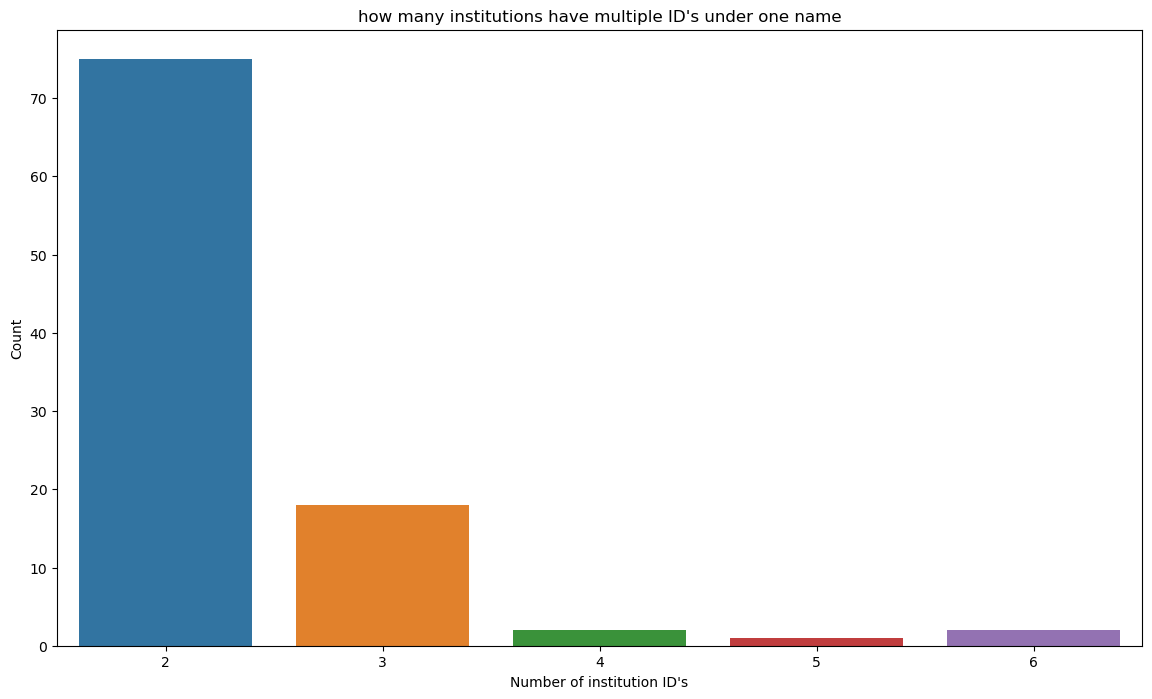

In [31]:
# find the count of institutions by the same name with multiple ID's 
num_UNITID_per_INSTNM = data.groupby("INSTNM").UNITID.count()
multiple_UNITID_per_INSTNM = num_UNITID_per_INSTNM[num_UNITID_per_INSTNM>1]
counts = multiple_UNITID_per_INSTNM.value_counts().sort_index()

# bar plot of how many institution ID's a name is attached to
ax = plt.subplot()
sns.barplot(x=counts.index.values, y=counts)
ax.set_title("how many institutions have multiple ID's under one name")
ax.set_ylabel("Count")
ax.set_xlabel("Number of institution ID's")
ax.set_xticklabels(counts.index.values)
ax.grid(False)
plt.savefig('figures/institution_id.png');

Most institutions are only connected to one institution ID and name, but there are enough names connected to multiple institutions ID's(especially 2 ID's) that they could represent a different relationship with student retention. 

Let's explore these potential parent institutions' ```PRFMOFR``` of the same name separately from ```PRGMOFR``` as a whole.

In [32]:
#aggregate information on institution by each name
instid_per_instnm = data.groupby("INSTNM")[["UNITID", "PRGMOFR", "CITY", "RET_FT4", "RET_FTL4"]]\
    .agg([list, len])\
    .sort_values([("RET_FTL4", "len")], ascending=False)\
    .drop(columns=[(col, "len") for col in ["UNITID", "PRGMOFR", "CITY", "RET_FT4"]])
instid_per_instnm.head()

UNITID  \
                                                                      list   
INSTNM                                                                       
Jersey College           [455196, 45519601, 45519602, 45519603, 4551960...   
Cortiva Institute         [128896, 134574, 215044, 387925, 434308, 438285]   
Columbia College                  [112561, 177065, 217934, 455983, 479248]   
Arthur's Beauty College                   [106360, 106494, 445540, 489830]   
Unitek College                          [459204, 476799, 479424, 45920401]   

                                                PRGMOFR  \
                                                   list   
INSTNM                                                    
Jersey College           [9.0, nan, nan, nan, nan, nan]   
Cortiva Institute        [1.0, 3.0, 1.0, 4.0, 2.0, 4.0]   
Columbia College              [nan, nan, nan, 8.0, 4.0]   
Arthur's Beauty College            [2.0, 2.0, 2.0, 2.0]   
Unitek College                     [nan, 2.0, 2.0, nan]   

                                                                      CITY  \
                                                                      list   
INSTNM                                                                       
Jersey College           [Teterboro, Tampa, Ewing, Jacksonville, Sunris...   
Cortiva Institute        [Cromwell, St. Petersburg, King of Prussia, Po...   
Columbia College         [Sonora, Columbia, Columbia, Vienna, Centreville]   
Arthur's Beauty College      [Fort Smith, Jacksonville, Conway, Jonesboro]   
Unitek College            [Fremont, South San Francisco, Hayward, Fremont]   

                                                 RET_FT4  \
                                                    list   
INSTNM                                                     
Jersey College            [nan, nan, nan, nan, nan, nan]   
Cortiva Institute         [nan, nan, nan, nan, nan, nan]   
Columbia College         [nan, 0.7062, 0.5904, nan, nan]   
Arthur's Beauty College             [nan, nan, nan, nan]   
Unitek College                     [0.85, nan, nan, nan]   

                                                    RET_FTL4      
                                                        list len  
INSTNM                                                            
Jersey College             [0.7021, nan, nan, nan, nan, nan]   6  
Cortiva Institute        [0.875, nan, nan, 0.8, nan, 0.6842]   6  
Columbia College           [0.534, nan, nan, 0.7938, 0.9012]   5  
Arthur's Beauty College     [0.7143, 0.4167, 0.7778, 0.5294]   4  
Unitek College                    [nan, 0.8958, 0.9302, nan]   4

As a sanity check, let's look at Unitek college. From a google search, it is in fact the same University with multiple campuses. 

It would be very difficult verify this for all of the institutions in the dataset, so let us first see if this analysis is worth pursuing by
- examining the correlation between programs offered and student retention rate among these potential parent institutions (by institution name). 
- comparing this correlation with that of between programs offered and student retention rate by institution ID.

In [33]:
#sum the PRGMOFR values for each institution name, 
#treating np.nan's as 1s as that is the minimum number of programs which can be offered
sum_list = lambda row: sum(np.nan_to_num(row.iloc[0], nan=1))
parent_inst_PRGMOFR = instid_per_instnm[[("PRGMOFR", "list")]]\
    .apply(sum_list, axis=1)

#average retention over the sub-institutions
avg_list = lambda row: (np.mean(np.nan_to_num(row.iloc[0], nan=1)), np.mean(np.nan_to_num(row.iloc[1], nan=1)))
parent_inst_RET = instid_per_instnm[[("RET_FT4", "list"), ("RET_FTL4", "list")]]\
    .apply(avg_list, axis=1, result_type="expand")\
    .rename(columns={0:"RET_FT4", 1:"RET_FTL4"})

# join columns for easy plotting
instid_per_instnm = parent_inst_RET.copy()
instid_per_instnm["PRGMOFR"] = parent_inst_PRGMOFR
instid_per_instnm.head()

,RET_FT4,RET_FTL4,PRGMOFR
INSTNM,,,
Jersey College,1.00000,0.95035,14.0
Cortiva Institute,1.00000,0.89320,15.0
Columbia College,0.85932,0.84580,15.0
Arthur's Beauty College,1.00000,0.60955,8.0
Unitek College,0.96250,0.95650,6.0


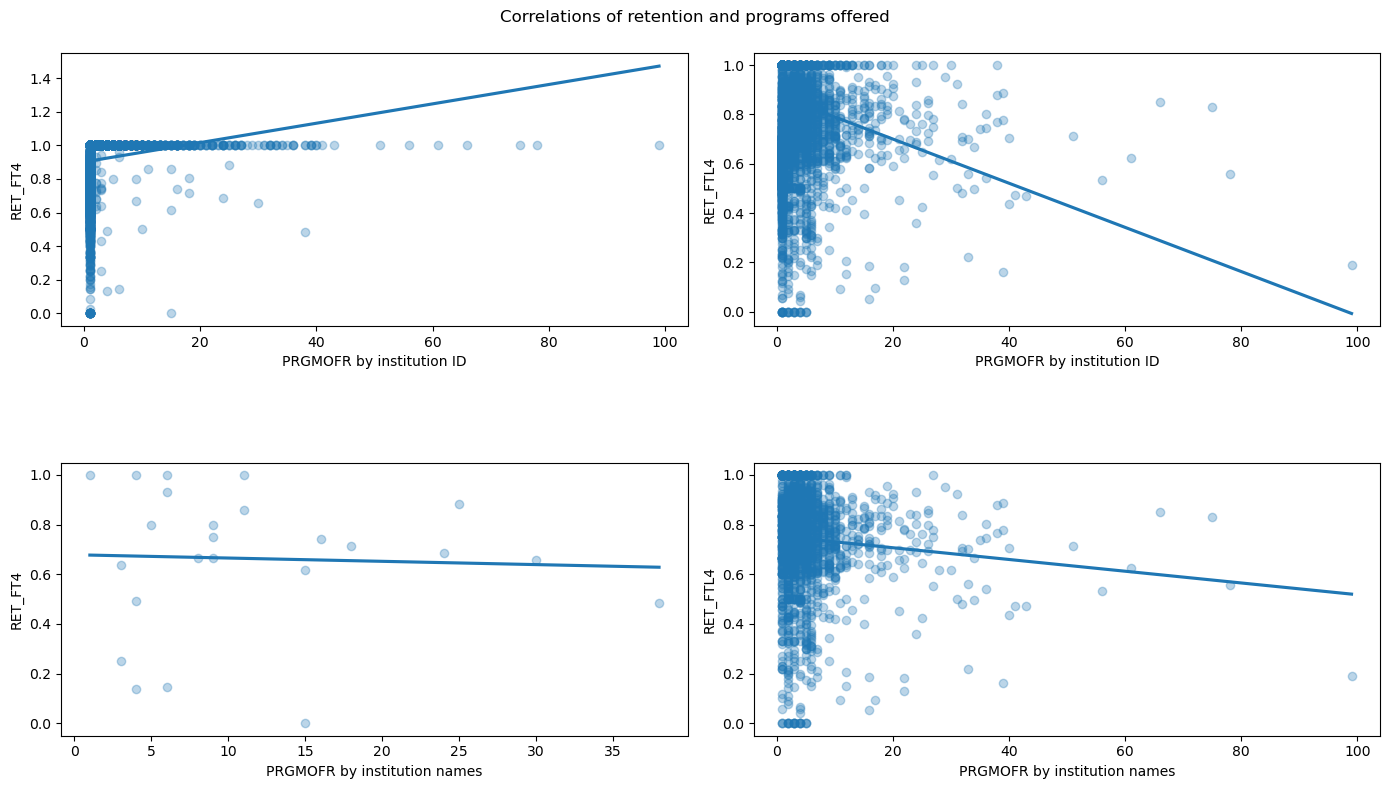

In [34]:
fig, axs = plt.subplots(2, 2)
sns.regplot(x = "PRGMOFR", y = "RET_FT4", data = instid_per_instnm, scatter_kws={'alpha':0.3}, ci=False, ax=axs[0,0])
axs[0,0].set_xlabel("PRGMOFR by institution ID")
pos = axs[0,0].get_position()
pos.y0 += .4
axs[0,0].set_position(pos)
sns.regplot(x = "PRGMOFR", y = "RET_FTL4", data = instid_per_instnm, scatter_kws={'alpha':0.3}, ci=False, ax=axs[0,1])
axs[0,1].set_xlabel("PRGMOFR by institution ID")
pos = axs[0,1].get_position()
pos.y0 += .4
axs[0,1].set_position(pos)
sns.regplot(x = "PRGMOFR", y = "RET_FT4", data = data, scatter_kws={'alpha':0.3}, ci=False, ax=axs[1,0])
axs[1,0].set_xlabel("PRGMOFR by institution names")
sns.regplot(x = "PRGMOFR", y = "RET_FTL4", data = data, scatter_kws={'alpha':0.3}, ci=False, ax=axs[1,1])
axs[1,1].set_xlabel("PRGMOFR by institution names")
fig.tight_layout()
fig.subplots_adjust(hspace=.5)
fig.suptitle("Correlations of retention and programs offered");
plt.savefig('figures/institution_id_corr.png')

Reasons for further exploration:
- Note that student retention on the y axis is strictly boundeded within [0, 1], including retention by our hypothesized parent institutions (instition name). This suggests that instititution ID's with the same corresponding names are, in fact, parent institutions. 

In [35]:
print("max retention of a parent institution: ", instid_per_instnm[["RET_FT4", "RET_FTL4"]].max().max())
print("min retention of a parent institution: ", instid_per_instnm[["RET_FT4", "RET_FTL4"]].min().min())

max retention of a parent institution:  1.0
min retention of a parent institution:  0.0


Reasons for skepticism:
- However, looking at the scatterplots, the relationships are not roughly linear and the correlations are weak so we will not pursue this variable further.

- It shuold be noted that some potential parent institutions could have more sub-institutions / ID's which aren't recorded. Similarly institutions could have the same name by conincedence and not be related. 

- Furthermore, a large proportion of ```PRGMOFR``` is null, meaning that our analysis on the non-nulls may not be representative of the sample and therefore of the population.

**Therefore, ```PRGMOFR``` cannot be proven to be significantly associated with student retention features ```RET_FT4``` and ```RET_FTL4```. If further information on parent-institutions becomes available, we can pursue this idea again.**